In [1]:
!pip install transformers

import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
from transformers import BertTokenizer
import seaborn as sns

newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))

news = newsData['data']
topic = newsData['target']
n_topic = len(set(topic))

subjects = []
y_topic = []
for text, top in zip(news, topic):
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:      
            subject = sent[(idx + 9):].replace('Re: ', '').lower()
            subject = re.sub("[^a-zA-Z]", " ", subject)
            if len(subject.split()) > 3: 
                subjects.append(subject)
                y_topic.append(top)
            break


     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 636 kB 64.8 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 895 kB 27.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[[101, 19142, 100, 1998, 100, 102], [101, 100, 3980, 2000, 28363, 102], [101, 100, 2449, 2004, 5156, 102], [101, 7808, 4770, 3627, 13921, 102], [101, 2054, 2106, 23623, 5437, 2066, 102], [101, 17053, 4003, 2005, 100, 102], [101, 2053, 2455, 2005, 3521, 2053, 100, 102], [101, 2003, 100, 14639, 100, 102], [101, 4816, 100, 2001, 2109, 13154, 3160, 102], [101, 19804, 3274, 8389, 7692, 10328, 4882, 2112, 102]]
max =  29


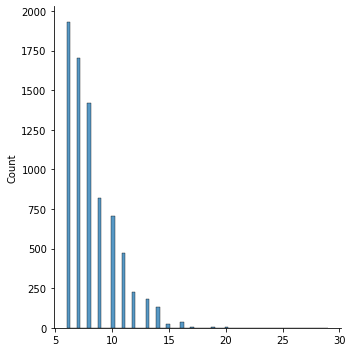

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='bert_eng_ckpt', do_lower_case=False)

subject_idx = [tokenizer.encode(s.split()) for s in subjects]
print(subject_idx[:10])

subject_len = [len(x) for x in subject_idx]
print('max = ', np.max(subject_len))
sns.displot(subject_len)

with open('/content/drive/MyDrive/news20_subject.pkl', 'wb') as f:
    pickle.dump([subjects, y_topic,subject_idx], f, pickle.DEFAULT_PROTOCOL)